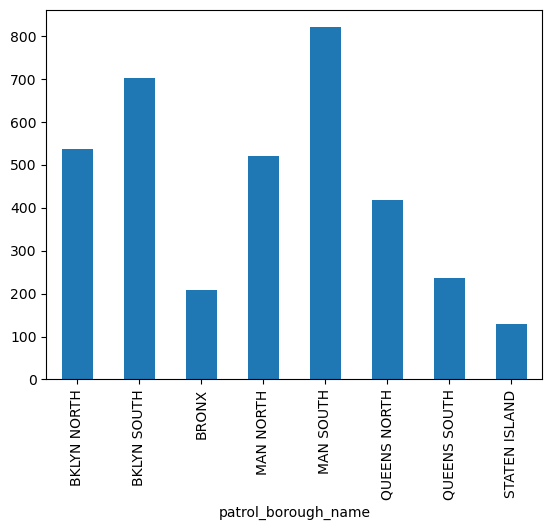

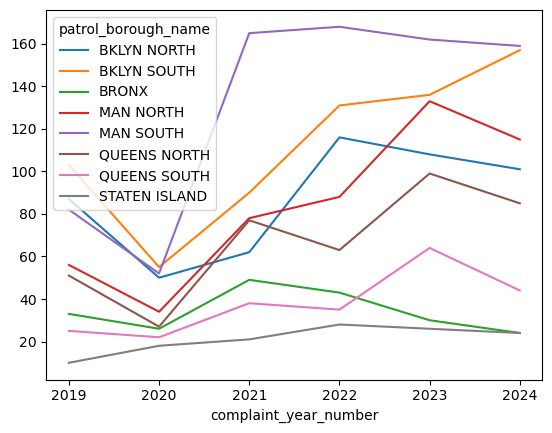

In [45]:
import pandas as pd
from sodapy import Socrata
import os
import matplotlib.pyplot as plt
import numpy as np
import re

HATECRIME_DATA_FILENAME = "hatecrime_opennyc.csv"
# if the file not exists, request the data from nyc open data.
if not os.path.exists(HATECRIME_DATA_FILENAME):
    client = Socrata("data.cityofnewyork.us", None)

    # there is only 3575, so I set limit=4000 to get all the data from it.
    results = client.get("bqiq-cu78", limit=4000)

    # Convert to pandas DataFrame
    results_df = pd.DataFrame.from_records(results)
    results_df.to_csv(HATECRIME_DATA_FILENAME, index = False)

# read data from csv file.
df = pd.read_csv(HATECRIME_DATA_FILENAME)

# remove some useless prefix in the data set.
df["patrol_borough_name"] = df["patrol_borough_name"].apply(lambda x: x.replace("PATROL BORO ", ""))
# analysis part.
by_year = df.groupby(["complaint_year_number","bias_motive_description"])["full_complaint_id"].count().reset_index()
by_region = df.groupby("patrol_borough_name")["full_complaint_id"].count().plot(kind="bar")


# group by year and region.
# for this part, I intentionally droped all the data in 2025, or the chart would show that there is a decline of hate-crime in 2025
# (Actually it is because 2025 is not end yet)
by_year_region = df[df["complaint_year_number"] != 2025].groupby(["complaint_year_number","patrol_borough_name"])["full_complaint_id"].count().unstack(level="patrol_borough_name").plot(kind="line")


# yoy change in hate crime incidents.
cnt_df = df.value_counts("bias_motive_description")

# tmp = df[df["complaint_year_number"] != 2025].groupby(["complaint_year_number", "bias_motive_description"])
# tmp["full_complaint_id"].count().unstack(level="bias_motive_description")[["JEWISH","ASIAN","MALE HOMOSEXUAL (GAY)","BLACK"]].plot(kind="line")



In [103]:
anti_jewish_yearly_change = df[df['bias_motive_description'] == "ANTI-JEWISH"]['complaint_year_number'].value_counts().sort_index()[:-1]
hate_crime_incidents = df['complaint_year_number'].value_counts().sort_index()[:-1]
# use lambda as a variable, very easy to understand I guess.
parse_pct = lambda x: (f"{x * 100:.2f}%" if not pd.isna(x) else "NA")
hate_crime_incidents = hate_crime_incidents.pct_change().apply(parse_pct)
anti_jewish_yearly_change = anti_jewish_yearly_change.pct_change().apply(parse_pct)
con = pd.concat([hate_crime_incidents,anti_jewish_yearly_change],axis=1)
con.reset_index(inplace = True)
con.columns = ["Year","Hate Crime Incidents Change","ANTI-Jewish Hate Crime Incidents Change"]
con.to_csv("hate_crime_and_anti_jewish_yearly_change.csv")
con

,Year,Hate Crime Incidents Change,ANTI-Jewish Hate Crime Incidents Change
0,2019,NA,NA
1,2020,-36.47%,-50.00%
2,2021,104.23%,70.63%
3,2022,15.86%,29.77%
4,2023,12.80%,22.94%
5,2024,-6.46%,7.87%


In [5]:

hate_crime_incidents = hate_crime_incidents.reset_index().rename(columns = {"complaint_year_number":"year","count":"change"})
hate_crime_incidents.to_csv("hatecrime_incidents_yearly_change.csv")
hate_crime_incidents

,year,change
0,2019,NA
1,2020,-36.47%
2,2021,104.23%
3,2022,15.86%
4,2023,12.80%
5,2024,-6.46%


In [7]:
df[df['bias_motive_description'] == "ANTI-JEWISH"]['complaint_year_number'].value_counts().sort_index()[:-1]

complaint_year_number
2019    252
2020    126
2021    215
2022    279
2023    343
2024    370
Name: count, dtype: int64

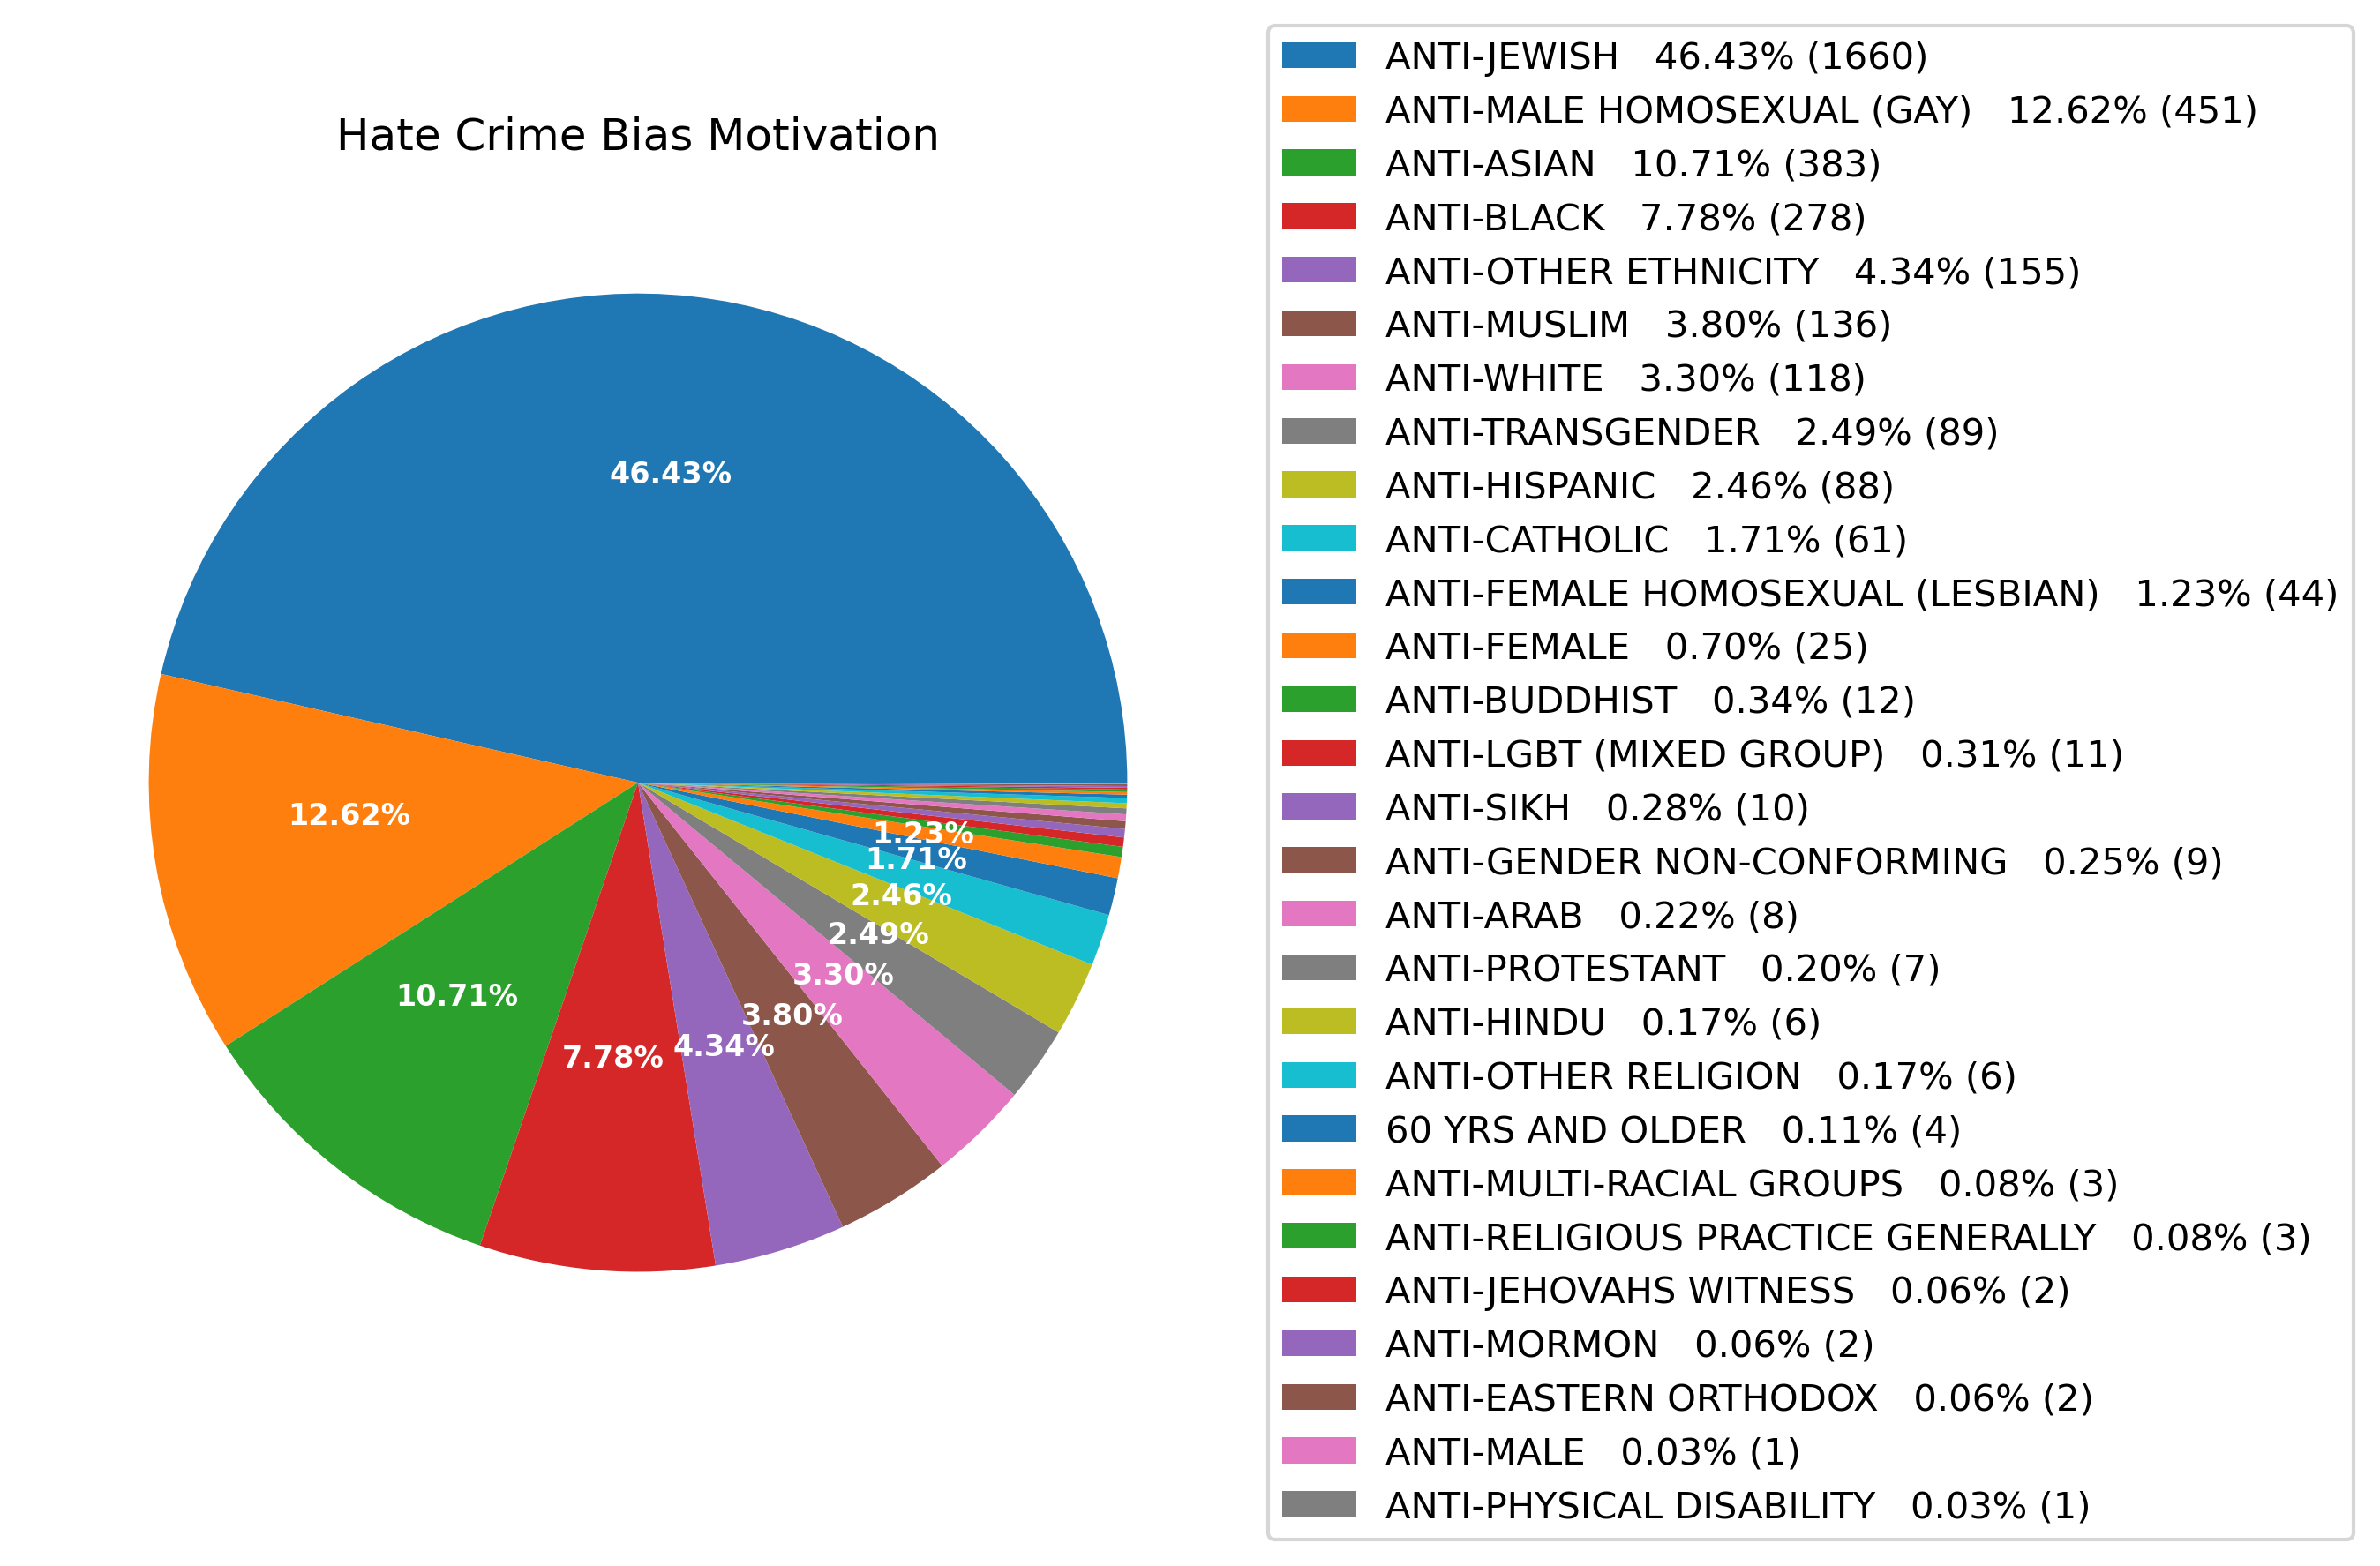

In [9]:
# draw a pie graph. I use some package not in our class(but actually it was used by pandas, so it is somehow, part of our class). 
# So I can draw a more, beauitiful pie grpah.
# here is the link(where I copy these code)
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def drawBiasMotivation(s):
    fig, ax = plt.subplots(figsize=(18, 6), dpi= 300, subplot_kw=dict(aspect="equal"))
    data = s.values
    labels = s.index
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: f"{pct:.2f}%\n" if pct > 1 else "", textprops=dict(color="w"))

    ax.legend(wedges, 
              [f"{label}   {(count / s.sum()) * 100:.2f}% ({count})"for count, label in zip(data, labels)],
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("Hate Crime Bias Motivation")
    plt.show()
drawBiasMotivation(df.value_counts("bias_motive_description"))
df.value_counts("bias_motive_description").to_csv("bias_motive_description.csv")


In [11]:
import os
import sodapy
import pandas as pd

HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010 = "hatecrime_by_county.csv"
# doesn't exist, use Socrata to get the data
if not os.path.exists(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010):
    client = sodapy.Socrata("data.ny.gov", app_token=None)

    res = client.get("6xda-q7ev", limit=1000)

    res_df = pd.DataFrame.from_records(res)
    res_df.to_csv(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010, index=False)

df = pd.read_csv(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010)
nyc_county_list = ["Bronx", "Kings", "New York", "Queens", "Richmond"]

df["anti_jewish"] = df["anti_jewish"].astype(int)
s1 = df[df["county"].isin(nyc_county_list)].groupby("year")[["anti_jewish"]].sum()
s2 = df[~ df["county"].isin(nyc_county_list)].groupby("year")[["anti_jewish"]].sum()
con = pd.concat([s1, s2], axis=1, ignore_index=True)
con = con.rename(columns={0: "nyc", 1: "out-of-nyc"})

In [13]:
# nyc / out of nyc, nyc has much higher anti-jewish data
con

,nyc,out-of-nyc
year,,
2010,137,83
2011,104,95
2012,218,124
2013,119,122
2014,126,109
2015,123,83
2016,138,104
2017,149,92
2018,192,61


In [15]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt

HATE_CRIME_BIAS_TYPE2023 = "hate_crime_bias_type_2023.xlsx"

# if file doesn't exist, get the data from url, write it into a file
if not os.path.exists(HATE_CRIME_BIAS_TYPE2023):
    res = requests.get("https://www.criminaljustice.ny.gov/crimnet/ojsa/hatecrimesbiastype2023.xlsx")
    with open(HATE_CRIME_BIAS_TYPE2023, "wb+") as f:
        f.write(res.content)

# read the file we downloaded.
df = pd.read_excel(HATE_CRIME_BIAS_TYPE2023)

# get the row which contains the data of total_incidents.
total_incidents_row = df.iloc[4]

# get the row which contains the data of anti_jewish incidents.
anti_jewish_row = df.iloc[9]

# list of years which was included in the data.
year_list = ["2019", "2020", "2021", "2022", "2023"]


def get_year_region_df(s):
    # only keep those numbers.
    s = s[2:]
    nystate = [s.iloc[i] for i in range(len(year_list))]
    nyc = [s.iloc[i + 5] for i in range(len(year_list))]
    non_nyc = [s.iloc[i + 10] for i in range(len(year_list))]
    df = pd.DataFrame({
        # "NYState":nystate,
        "NYC": nyc,
        "Non-NYC": non_nyc
    })
    df.index = year_list
    df.drop("2023", inplace=True)  # drop 2023 since there are NaN data.
    return df

anti_jewish_df = get_year_region_df(anti_jewish_row).astype(int)
total_incidents_df = get_year_region_df(total_incidents_row).astype(int)

In [17]:
anti_jewish_df # anti-jewish hate crime incidents, nyc and the rest of new york state

,NYC,Non-NYC
2019,242,102
2020,127,67
2021,190,81
2022,257,99


In [19]:
total_incidents_df # total hate crime incidents, nyc and the rest of new york state

,NYC,Non-NYC
2019,420,224
2020,272,233
2021,514,278
2022,594,372


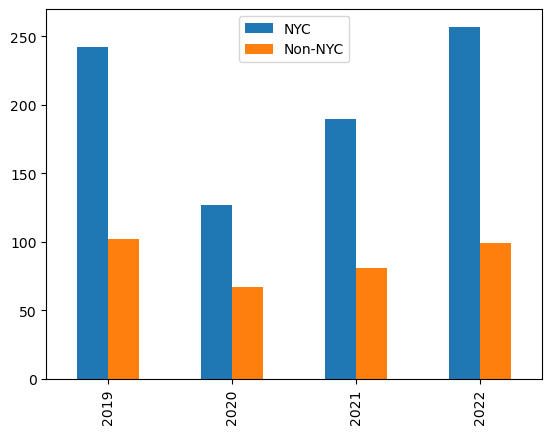

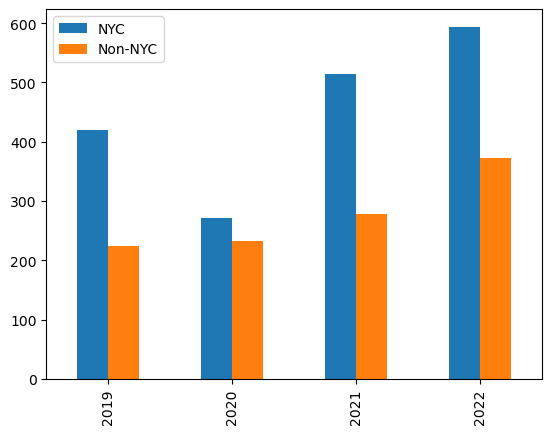

In [21]:
anti_jewish_df.plot(kind="bar")
anti_jewish_df.to_csv("anti_jewish_nyc_and_non_nyc.csv")
plt.show()
total_incidents_df.plot(kind="bar")
total_incidents_df.to_csv("total_incidents_df_nyc_and_non_nyc.csv")
plt.show()

In [23]:
import os

import sodapy
import pandas as pd
import matplotlib.pyplot as plt

HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010 = "hatecrime_by_county.csv"

# doesn't exist, use Socrata to get the data
if not os.path.exists(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010):
    client = sodapy.Socrata("data.ny.gov", app_token=None)
    res = client.get("6xda-q7ev", limit=1000)
    res_df = pd.DataFrame.from_records(res)
    res_df.to_csv(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010, index=False)

df = pd.read_csv(HATE_CRIME_BY_COUNTY_BIAS_BEGINNING_2010)
nyc_county_list = ["Bronx", "Kings", "New York", "Queens", "Richmond"]
df["total_incidents"] = df["total_incidents"].astype(int)
s1 = df[df["county"].isin(nyc_county_list)].groupby("year")[["total_incidents"]].sum()
s2 = df[~ df["county"].isin(nyc_county_list)].groupby("year")[["total_incidents"]].sum()
con = pd.concat([s1, s2], axis=1, ignore_index=True)
con = con.rename(columns={0: "New York City", 1: "Rest of State"})
con.to_excel("beginning2010.xlsx")